In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng_permute = np.random.RandomState(92916)
idx_permute = rng_permute.permutation(784)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Lambda(lambda x: x.view(-1)[idx_permute].view(1, 28, 28) )])
train_dataset = datasets.MNIST(root='./data', transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', transform=transform, download=True)
batch_size=100
epochs = 10
trainloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True)



print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the trainloader set'.format(len(trainloader)))
print('There are {} batches in the testloader set'.format(len(testloader)))


9920512it [00:02, 3457723.23it/s]                                                                                      


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz


32768it [00:00, 91810.69it/s]                                                                                          


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz


1654784it [00:01, 1546237.79it/s]                                                                                      


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz


8192it [00:00, 29252.71it/s]                                                                                           


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!
There are 60000 images in the training set
There are 60000 images in the test set
There are 600 batches in the trainloader set
There are 600 batches in the testloader set


In [3]:

#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is 
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=24, kernel_size=5, stride=3, padding=2)
        #Output size of each of the 24 feature maps remains 16
        self.batchnorm2 = nn.BatchNorm2d(24)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is 16/2 = 8
        #Flatten the feature maps. You have 24 feature maps, each of them is of size 8*8 --> 24*8*8 = 1536
        self.fc1 = nn.Linear(in_features=1536, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 1536) = (100, 1536)
        out = out.view(-1,1536)
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [4]:

model = CNN()  
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [5]:
#Training the CNN
print('Start training')
num_epochs = 10

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for data in trainloader:

        # get the inputs
        inputs, labels = data  
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
       
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.data          # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for data in testloader:

        # get the inputs
        inputs, labels = data  
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
     
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        loss += loss.data
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Start training
Epoch 1/10, Training Loss: 1.018, Training Accuracy: 72.000, Testing Loss: 0.002, Testing Acc: 88.000
Epoch 2/10, Training Loss: 0.413, Training Accuracy: 87.000, Testing Loss: 0.001, Testing Acc: 91.000
Epoch 3/10, Training Loss: 0.318, Training Accuracy: 90.000, Testing Loss: 0.001, Testing Acc: 92.000
Epoch 4/10, Training Loss: 0.266, Training Accuracy: 92.000, Testing Loss: 0.001, Testing Acc: 93.000
Epoch 5/10, Training Loss: 0.235, Training Accuracy: 93.000, Testing Loss: 0.001, Testing Acc: 94.000
Epoch 6/10, Training Loss: 0.211, Training Accuracy: 93.000, Testing Loss: 0.000, Testing Acc: 95.000
Epoch 7/10, Training Loss: 0.193, Training Accuracy: 94.000, Testing Loss: 0.001, Testing Acc: 95.000
Epoch 8/10, Training Loss: 0.178, Training Accuracy: 94.000, Testing Loss: 0.001, Testing Acc: 95.000
Epoch 9/10, Training Loss: 0.165, Training Accuracy: 95.000, Testing Loss: 0.000, Testing Acc: 96.000
Epoch 10/10, Training Loss: 0.156, Training Accuracy: 95.000, Testi

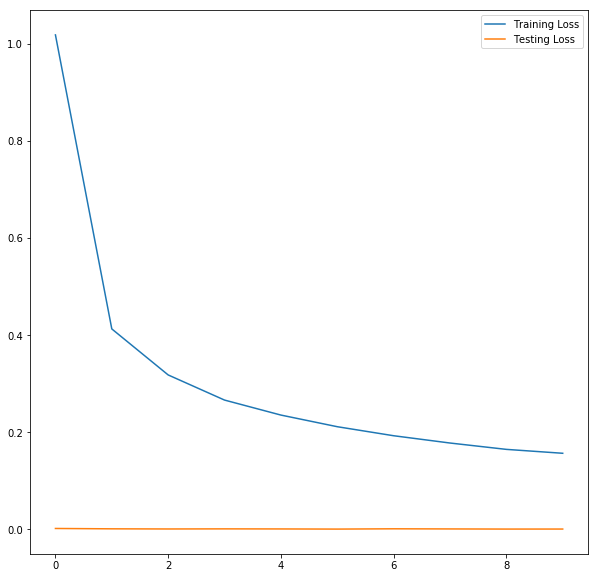

In [6]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

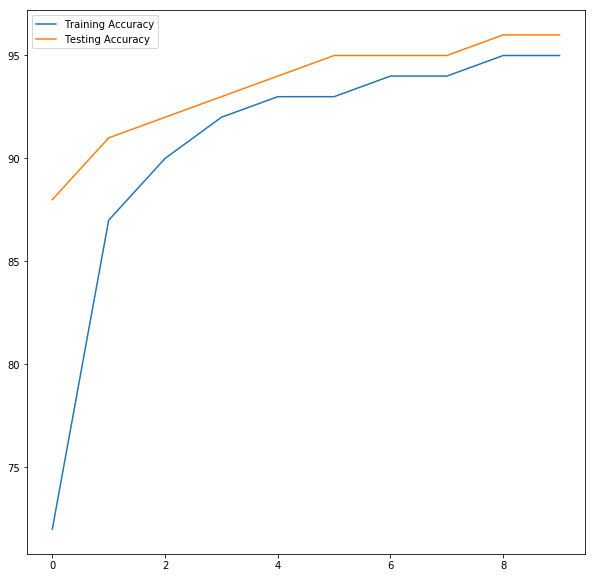

In [7]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()